# PAN Homework I

## Imports

In [15]:
import cv2
import numpy as np
from numpy import ndarray
from matplotlib import pyplot as plt
from secrets import randbelow

## Parameters

In [16]:
IMAGES_DIRECTORY: str = './img/'
ORIGINAL_PATH: str = IMAGES_DIRECTORY + 'nopadron.png'
FILTERED_PATH: str = IMAGES_DIRECTORY + 'filtered.png'
HOMOMORPHIC_FILTERED_PATH: str = IMAGES_DIRECTORY + 'homomorphic_filtered.png'

In [17]:

n: int = 128  # Length of the unique secret key s
q: int = 2**24  # Modulus
delta: int = 2**10  # Parameter ∆

kernel: ndarray = np.asarray([
    [-1, -1, -1],
    [-1,  8, -1],
    [-1, -1, -1]
])

alpha_values: list[float] = [5e-07, 5e-06, 5e-05, 5e-04, 5e-03]

> All necessary vectors a (and you will need a very large quantity of them) are generated taking
uniform samples from Z<sup>n</sup><sub>q</sub>.

> For simplicity, the image provided by Alice will be in grayscale, this means that each pixel contains
only one value of luminance which is an integer in `[0, 255]`.

## Read image

(384, 512)


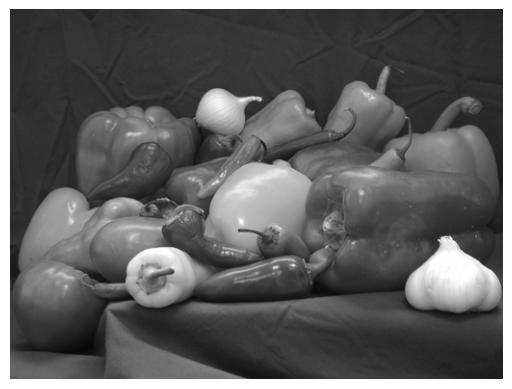

In [18]:
image: ndarray = np.array(cv2.imread(ORIGINAL_PATH, cv2.IMREAD_GRAYSCALE))
plt.axis('off')
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
print(image.shape)

## Process image

### Add padding

> In order to keep the size of the input image after the convolution, it is customary to extend the input on its borders. In the reference implementation, this is done by zero-padding, that is, attaching zeros on the borders of the image.

In [19]:
# Number of padded pixels on each side
pd_len: int = (np.shape(kernel)[0]-1)//2

# Pad with zeros on the outer border to produce a filtered image
# with the same size as the original
pd_image: ndarray = np.pad(image, pad_width=pd_len,
                           mode='constant', constant_values=0)

### Type assurance

In [20]:
# VERY IMPORTANT: when working with encrypted signals, convert to
# integer, to avoid problems in the encryptions. Here it's innocuous.
pd_image: ndarray = pd_image.astype(int)

### Utils

In [21]:
def signed_mod(v, q):
    r = v % q
    return np.where(r > q//2 - 1, r - q, r)


def errorgen(size, alpha, q):
    sample = (np.rint(np.random.normal(
        loc=0, scale=alpha*q, size=size))).astype(int)
    return signed_mod(sample, q)


def get_s(size: int) -> ndarray:
    return np.array([randbelow(3) - 1 for _ in range(size)])


def get_a(size: int, q: int) -> ndarray:
    return np.random.randint((-q//2), (q//2), size=size)

### Encrypt image

> The elements of the secret key are chosen independently and with uniform probability from the set {-1, 0, 1}.

In [22]:
def encrypt(s: ndarray, error: float, q: int, delta: int, n: int,
            image_to_encrypt: ndarray) -> tuple[ndarray, ndarray]:

    def encrypt_pixel(s: ndarray, a: ndarray, error: float, q: int, delta: int,
                      m: int) -> ndarray:
        return signed_mod((np.matmul(s.transpose(), a) + error + (delta * m)),
                          q)

    a_matrix: ndarray = np.zeros(image_to_encrypt.shape + (n,))
    b_matrix: ndarray = np.zeros(image_to_encrypt.shape)

    error_matrix = errorgen(b_matrix.shape, error, q)

    # Encryption
    for i_index, i_value in enumerate(image_to_encrypt):
        for j_index, j_value in enumerate(i_value):
            a: ndarray = get_a(n, q)
            error: int = error_matrix[i_index][j_index]
            a_matrix[i_index][j_index] = a.copy()
            b_matrix[i_index][j_index] = encrypt_pixel(
                s, a, error, q, delta, j_value)

    return a_matrix, b_matrix


s: ndarray = get_s(n)  # Secret key
error: float = alpha_values[0]
a_matrix, b_matrix = encrypt(s, error, q, delta, n, pd_image)

print(a_matrix.shape)
print(b_matrix.shape)

(386, 514, 128)
(386, 514)


### Apply filter

In [23]:
def filter_image(a_matrix: ndarray, b_matrix: ndarray,
                 kernel: ndarray) -> tuple[ndarray, ndarray]:

    # Create container for output image
    a_out_image: ndarray = np.zeros(np.shape(a_matrix))
    b_out_image: ndarray = np.zeros(np.shape(b_matrix))

    # Do the convolution
    for i in range(np.shape(image)[0]):
        for j in range(np.shape(image)[1]):
            a_block = a_matrix[i:i+2*pd_len+1, j:j+2*pd_len+1]
            b_block = b_matrix[i:i+2*pd_len+1, j:j+2*pd_len+1]
            a_out_image[i][j] = np.sum(np.multiply(
                a_block, kernel[:, :, np.newaxis]), axis=(0, 1))
            b_out_image[i][j] = np.sum(np.multiply(b_block, kernel))

    return a_out_image, b_out_image


a_out_image, b_out_image = filter_image(a_matrix, b_matrix, kernel)

### Decrypt

In [24]:
def decrypt(s: ndarray, a: ndarray, b: ndarray, q: int, delta: int) -> ndarray:

    def decrypt_pixel(s: ndarray, a: ndarray, b: int, q: int,
                      delta: int) -> int:
        return round(signed_mod((b - np.matmul(s.transpose(), a)), q)/delta)

    out_image: ndarray = np.zeros(np.shape(image))

    # Decryption
    for i in range(np.shape(image)[0]):
        for j in range(np.shape(image)[1]):
            out_image[i][j] = decrypt_pixel(
                s, a_out_image[i, j], b_out_image[i][j], q, delta)

    return out_image


out_image: ndarray = decrypt(s, a_out_image, b_out_image, q, delta)

## Output

### Save result

In [25]:
# Convert to values in range [0,255] by saving
cv2.imwrite(HOMOMORPHIC_FILTERED_PATH, out_image)
out_image = cv2.imread(HOMOMORPHIC_FILTERED_PATH)

### Display

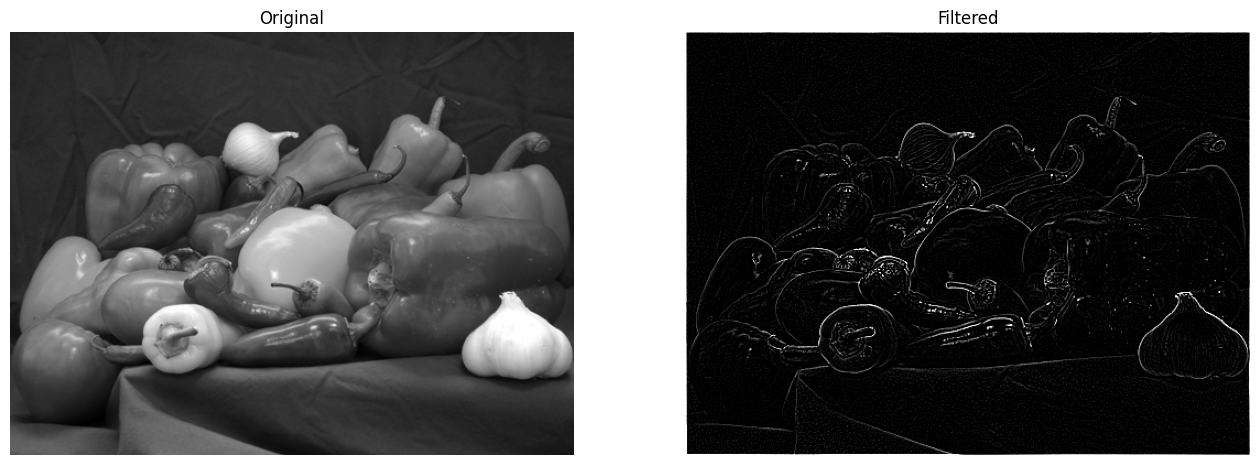

In [26]:
def display_figures(original_image, filtered_image) -> None:
    fig = plt.figure(figsize=(16, 25))
    ax1 = fig.add_subplot(2, 2, 1)
    ax1.axis("off")
    ax1.title.set_text('Original')
    ax1.imshow(original_image, cmap='gray')
    ax2 = fig.add_subplot(2, 2, 2)
    ax2.axis("off")
    ax2.title.set_text('Filtered')
    ax2.imshow(filtered_image)
    return


display_figures(image, out_image)

## Analisis

> Besides plotting the result, measure the square error (i.e., squared ℓ2-norm) between the two results (in the clear and after encryption-
filtering-decryption); if α is suficiently small, the error should be zero.

In [27]:
def squared_l2_norm(x: ndarray):
    return np.sum(x**2)

Alpha: 5e-07
Squared L2 norm: 0


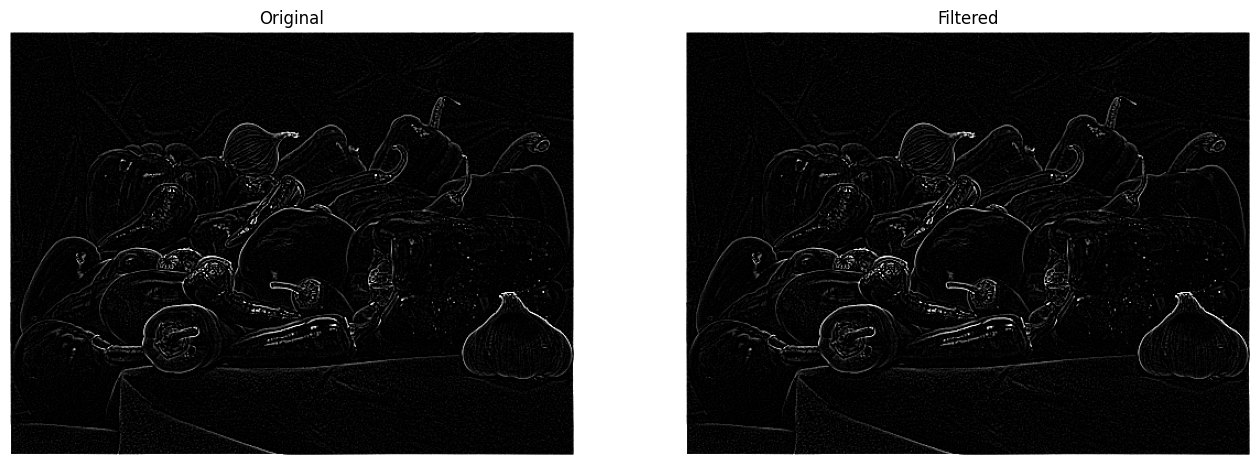

Alpha: 5e-06
Squared L2 norm: 168231


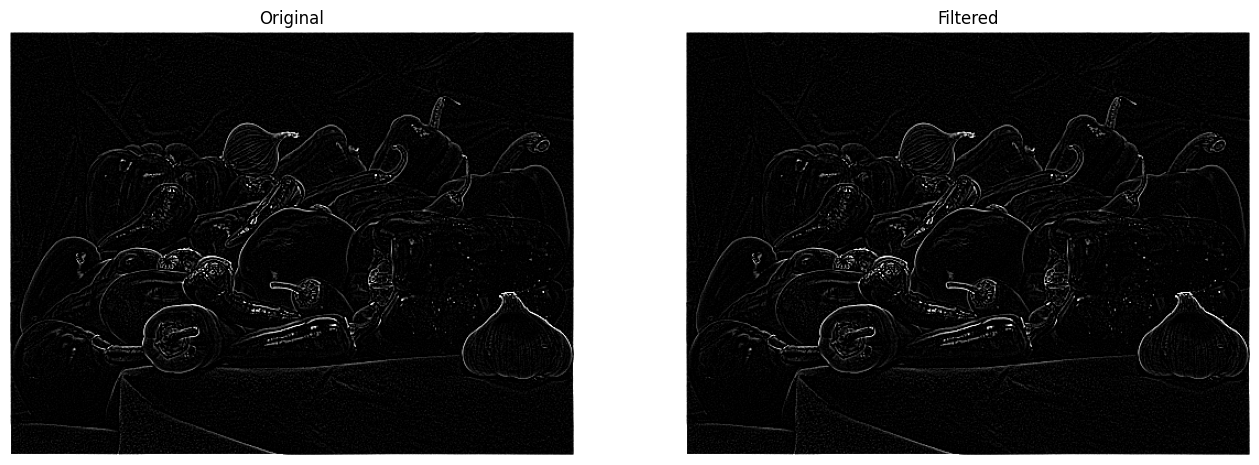

Alpha: 5e-05
Squared L2 norm: 11461530


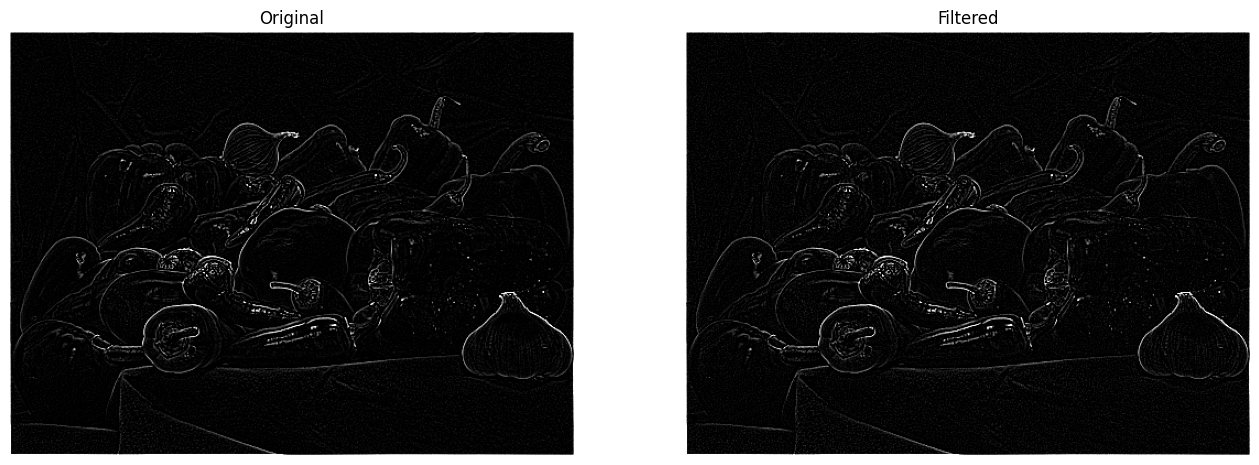

Alpha: 0.0005
Squared L2 norm: 37648092


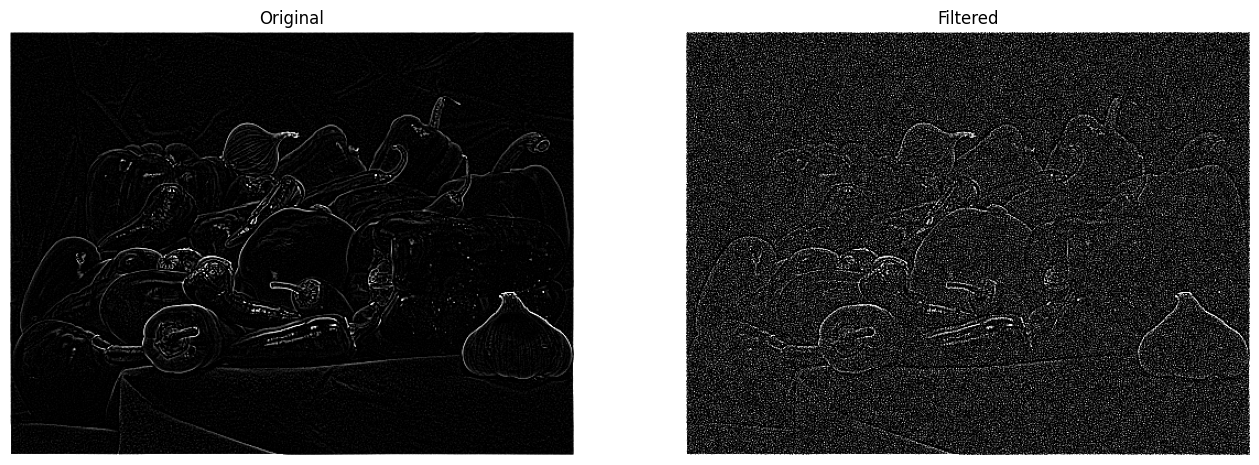

Alpha: 0.005
Squared L2 norm: 25800303


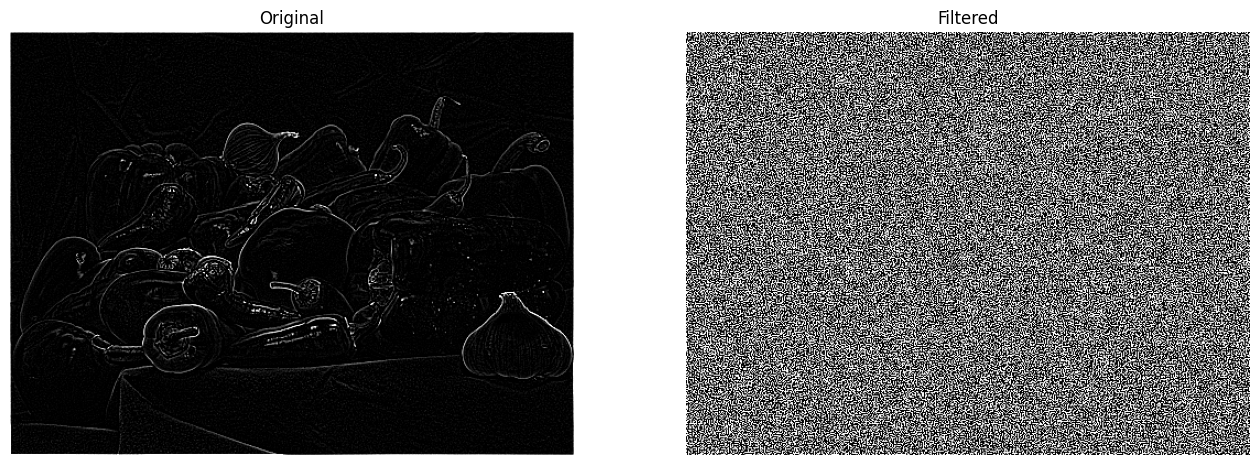

In [28]:
s: ndarray = get_s(n)  # Secret key

filtered_image = cv2.imread(FILTERED_PATH)
for alpha in alpha_values:
    a_matrix, b_matrix = encrypt(s, alpha, q, delta, n, pd_image)
    a_out_image, b_out_image = filter_image(a_matrix, b_matrix, kernel)
    out_image: ndarray = decrypt(s, a_out_image, b_out_image, q, delta)
    out_image_path_: str = IMAGES_DIRECTORY + f'hf_{str(alpha)}.png' 
    cv2.imwrite(out_image_path_, out_image)
    out_image = cv2.imread(out_image_path_)
    print(f'Alpha: {alpha}')
    print('Squared L2 norm: ', end='')
    print(squared_l2_norm(out_image - filtered_image))
    display_figures(filtered_image, out_image)
    plt.show()

## Discussion

The following table shows the alpha values used during the generation of the error matrix used during homomorphic encryption and the squared l2 norm value applied to the difference of the filtered and encrypted-filtered-decrypted images:

|α|Squared ℓ2-norm |
|:--:|--:|
|5e-07|0|
|5e-06|165498|
|5e-05|11333412|
|5e-04|37552632|
|5e-03|25892115|

It can be seen that in the case of very small alphas (such as 5e-07) the calculated error is 0.

The growth of the error with respect to the growth in orders of magnitude of alpha is also notable.

Visually, it can be seen that for the first three alpha values the resulting image is quite similar to the unencrypted filtered one, while in the fourth the added noise is considerable, and with the largest value practically the entire image is noise.